# Low-dimensional representation of spectral envelope

In [46]:
import os
import numpy as np
import argparse
import time
import librosa
import librosa.display

In [47]:
from utils import *

In [48]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Audio

In [49]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/jg/.conda/envs/tf18_p35/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['square', 'bartlett', 'correlate', 'detrend', 'blackman', 'step', 'convolve', 'exponential', 'random', 'kaiser', 'csd', 'hanning', 'hamming']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [50]:
import seaborn
seaborn.set(style="dark")
rcParams['figure.figsize'] = (16, 4)

In [51]:
import pysptk
import pyworld

## Spectral envelope parametrization & recovering

In [52]:
def decompose(x, fs, period=5.0):
    """using WORLD, waveform = F0 + spectral envelope (sp) + aperiodicity (ap)
    """
    f0, timeaxis = pyworld.harvest(x, fs, frame_period=period)
    sp = pyworld.cheaptrick(x, f0, timeaxis, fs)
    ap = pyworld.d4c(x, f0, timeaxis, fs)
    return f0, timeaxis, sp, ap


In [53]:
def vis(sp_param, approx_sp, x, y, top_title):
    """Visualization of compressed spectral parameter, recovered spectral envelope, reconstructed speech wavevform
    """
    figure(figsize=(16,14))
    subplots_adjust(hspace=0.4)
    subplot(3,1,1)
    librosa.display.specshow(sp_param.T, sr=sampling_rate, hop_length=hop_length, x_axis="time", y_axis="linear")
    title(top_title)
    subplot(3,1,2)
    librosa.display.specshow(10*log(approx_sp).T, sr=sampling_rate, hop_length=hop_length, x_axis="time", y_axis="linear")
    title("20log|H(w)|")
    subplot(3,1,3)
    plot(y, "r-+", label="reconstructed speech signal")
    plot(x, label="original speech signal")
    xlabel("sample")
    legend(fontsize=14)


In [54]:
def mcepalpha(fs):
    """Determine frequency warping parameter from fs (simplest implementation)
    See https://bitbucket.org/happyalu/mcep_alpha_calc/ for details.
    """
    if fs == 16000:
        return 0.41
    elif fs == 22050:
        return 0.455
    elif fs == 44100:
        return 0.544
    elif fs == 48000:
        return 0.554
    else:
        raise NotImplementedError

### Load speech in our database

In [55]:
train_A_dir = './../../../Database/Emotion/ang_neu/ang'
train_B_dir = './../../../Database/Emotion/ang_neu/neu'
validation_A_dir = './../../../Database/Emotion/ang_neu/val_ang'
validation_B_dir = './../../../Database/Emotion/ang_neu/val_neu'

In [98]:
# load speech waveform
sampling_rate = 48000
wavs_A = load_wavs(wav_dir = validation_A_dir, sr = sampling_rate)
wavs_B = load_wavs(wav_dir = validation_B_dir, sr = sampling_rate)

(116640,)


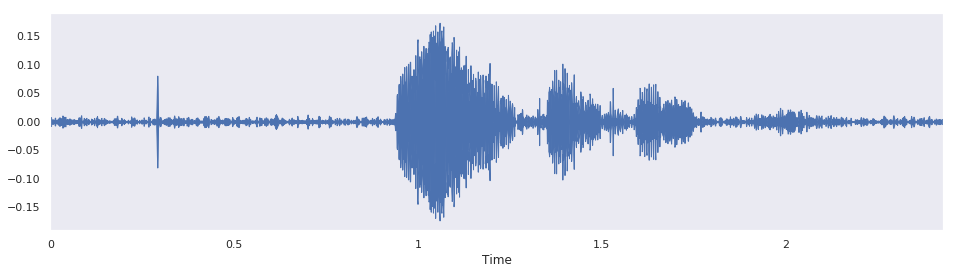

In [99]:
x = wavs_B[-1]
print(np.shape(x))
librosa.display.waveplot(x, sr=sampling_rate)
Audio(x, rate=sampling_rate)

### Load speech in pysptk

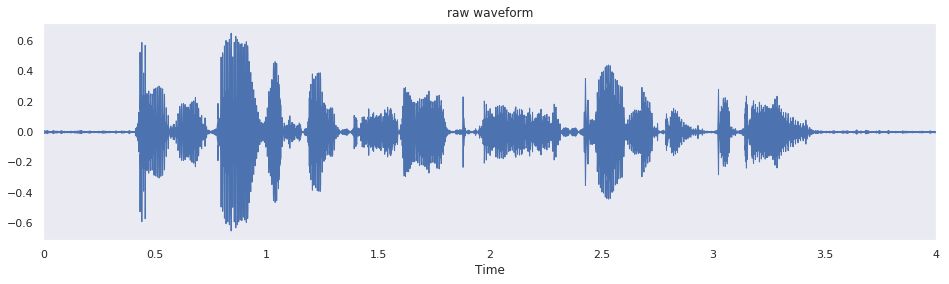

In [72]:
path = pysptk.util.example_audio_file()
x, fs = librosa.load(path, sr=None)
x = x.astype(np.float64)

librosa.display.waveplot(x, sr=fs)
title("raw waveform")
Audio(x, rate=fs)

In [84]:
frame_period = 5.0
hop_length = int(sampling_rate * frame_period * 0.001)
fftlen = pyworld.get_cheaptrick_fft_size(sampling_rate)
x = x.astype(np.float64)
f0, timeaxis, sp, ap = decompose(x, sampling_rate, frame_period)

print(hop_length)
print(sp.shape)
print(fftlen)

240
(487, 1025)
2048


### Fundamental frequency F0

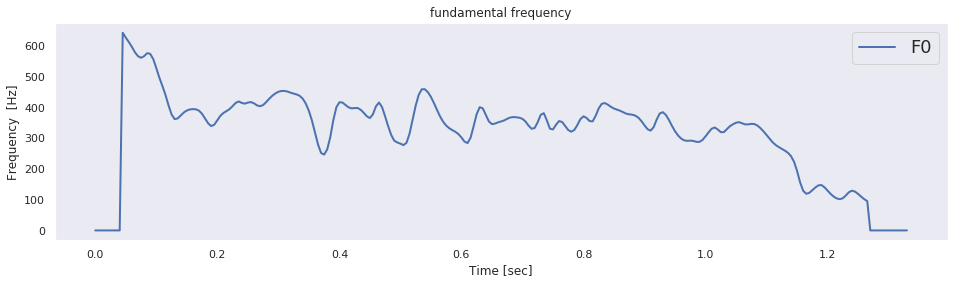

In [74]:
plot(timeaxis, f0, linewidth=2, label="F0") #  F0 contour estimated by pyworld.harvest
title("fundamental frequency")
xlabel("Time [sec]")
ylabel("Frequency  [Hz]")
legend(fontsize=18);

### Power envelope $e(t)^2 = LPF[Hilbert[x(t)^2]]$

In [75]:
from scipy import signal
from scipy.signal import *

In [76]:
def LPF(x, fc=20, fs=16000):
    # fc: Cut-off frequency of the low pass filter
    w = fc / (fs / 2) # Normalize the frequency
    b, a = signal.butter(5, w, 'low')
    return signal.filtfilt(b, a, x)

In [77]:
def abs2(x):
    return x.real**2 + x.imag**2

/home/jg/.conda/envs/tf18_p35/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/home/jg/.conda/envs/tf18_p35/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


Text(0.5, 0, 'sample')

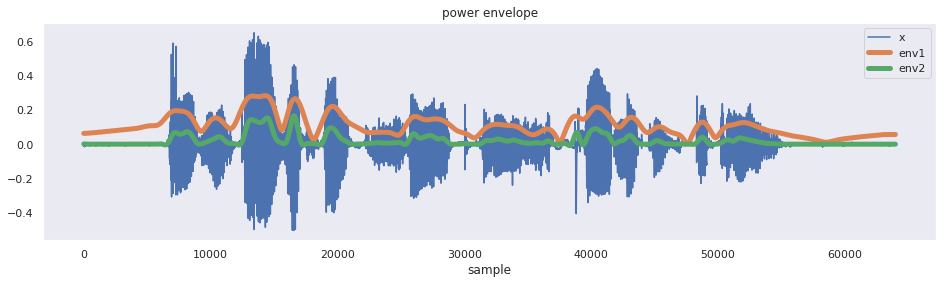

In [78]:
# Hilbert
x1 = abs(hilbert(np.square(x)))

# LPF
env1 = np.sqrt(LPF(x1, fc=30, fs=sampling_rate))
env2 = LPF(abs2(x + hilbert(x)*1j))

logenv1 = 10*np.log10(env1)
logenv2 = 10*np.log10(env2)

plt.plot(x)
plt.plot(env1, linewidth=5.0)
plt.plot(env2, linewidth=5.0)
plt.title('power envelope')
legend(['x', 'env1', 'env2'])
xlabel('sample')

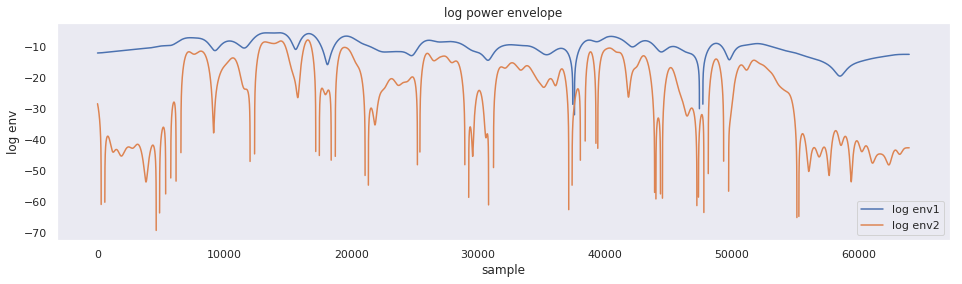

In [79]:
plt.plot(logenv1)
plt.plot(logenv2)
plt.title('log power envelope')
xlabel('sample')
ylabel('log env')
legend(['log env1', 'log env2'])

## Recovering from coded spectral envelope by WORLD

NMSE: 0.013921053764172875


/home/jg/.local/lib/python3.5/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


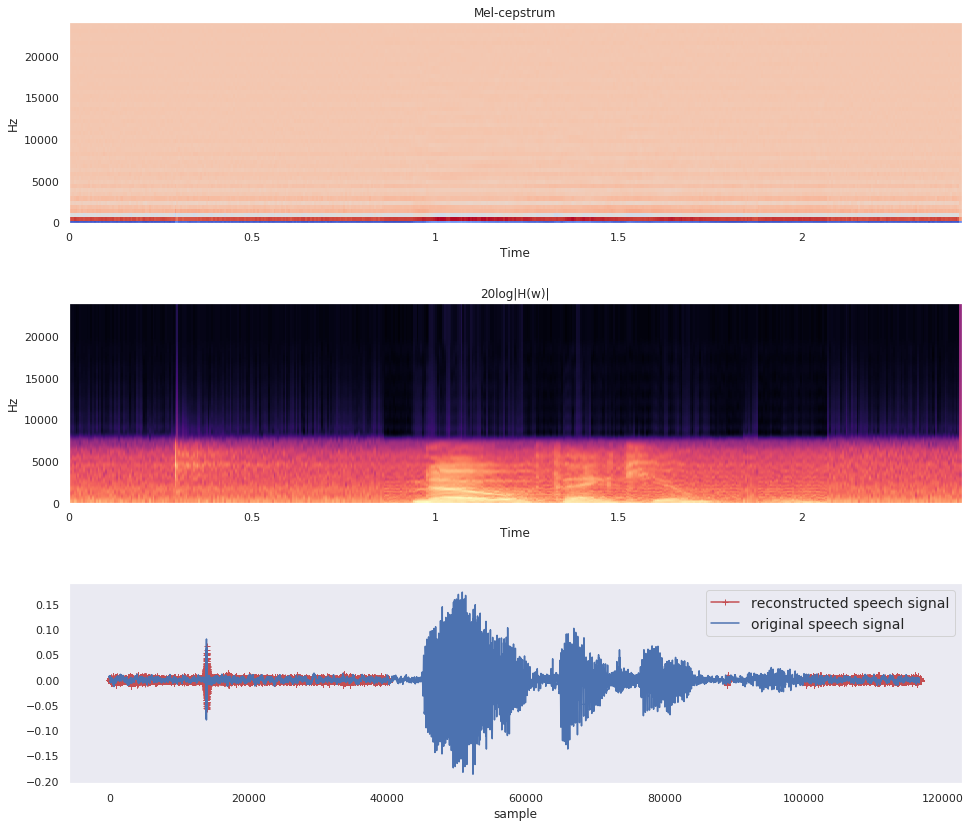

In [100]:
dim = 50
coded_sp = pyworld.code_spectral_envelope(sp, sampling_rate, dim)
decoded_sp = pyworld.decode_spectral_envelope(coded_sp, sampling_rate, fftlen)
y = pyworld.synthesize(f0, decoded_sp, ap, sampling_rate, frame_period)

nmse = np.linalg.norm(np.log(sp) - np.log(decoded_sp)) / np.linalg.norm(np.log(sp))
print("NMSE: {}".format(nmse))

vis(coded_sp, decoded_sp, x, y, "Mel-cepstrum")
Audio(y, rate=sampling_rate)